In [1]:
import json
import matplotlib.pylab as plt
import matplotlib.colors as colors
import numpy as np
import os

import lib.helper as hl
import lib.cell_plot as cplt

% matplotlib inline

In [2]:
current_dir = os.getcwd()
file_name = '2018_12_5_14_1_all'
dir_name = os.path.join(current_dir, 'data', 'results')
final_figs_dir = os.path.join(dir_name, file_name, 'final_figs')
ext = '.png'

hl.create_folder(final_figs_dir)
print 'plotting for: ', dir_name + '/' + file_name

plotting for:  /home/maria/maja/code/lfp-paper/data/results/2018_12_5_14_1_all


## 1. plot overall synapse distribution

In [3]:
neuron_no = 1 # number of morphology of neurons plotted

/home/maria/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


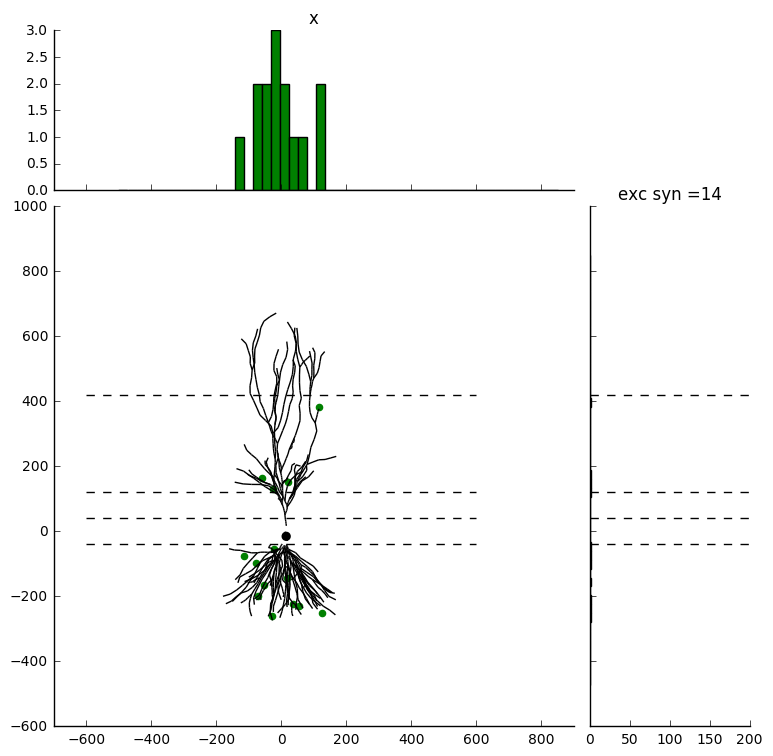

In [4]:
results_file = os.path.join(dir_name, file_name, 'results_all.npz')
results = np.load(results_file)
inh_syn_coords = results['inh_syn_coords']
exc_syn_coords = results['exc_syn_coords']

params_cell_file = os.path.join(dir_name, file_name) + '.json'
with file(params_cell_file, 'r') as fid:
    params_cell = json.load(fid)
    
x_range = params_cell['space_x_range']
y_range = params_cell['space_y_range']
layers = params_cell['region_layer_ranges']

axScatter, axHistx, axHisty = cplt.plot_synapse_dist(inh_syn_coords, exc_syn_coords,x_range=x_range,
                                                    y_range=y_range,layers=layers)

plt.sca(axScatter)

cell_path = os.path.join(dir_name, file_name, 'cell/params/')
cplt.plot_neuron(neuron_no, cell_path, params_cell)

## 2. plot CSD

In [5]:
x_value = -1
final_time = 10

/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


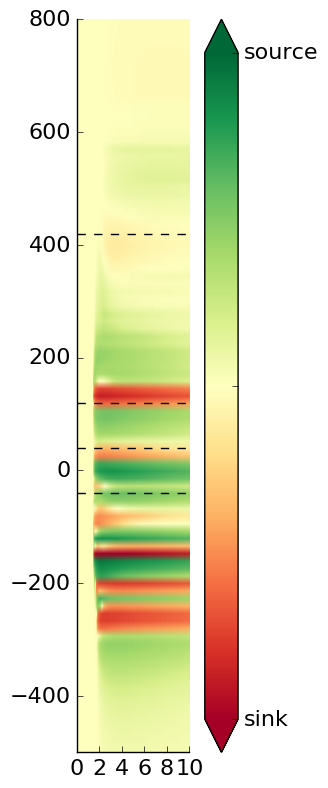

In [6]:
results_file = os.path.join(dir_name, file_name, 'results_all.npz')
results = np.load(results_file)
v_ext = results['v_ext']

params_cell_file = os.path.join(dir_name, file_name) + '.json'
with file(params_cell_file, 'r') as fid:
    params_cell = json.load(fid)
timestep = params_cell['timestep']
y_range = params_cell['record_y_range']
x_range = params_cell['record_x_range']
layers = params_cell['region_layer_ranges']
dt = params_cell['timestep']

if final_time is not None:
    final_time_pt = final_time/dt
    v_ext = v_ext[:final_time_pt,:,:]

    plt.figure(figsize = (4, 8))
    # plot csd
    if x_value == -1:
        # calculate the average accross all v_ext
        values = np.mean(v_ext, 2)
    else:
        values = v_ext[:, :, x_value]
    csd_val = -np.diff(values, n=2, axis=1)
    
    ax2 = plt.subplot(111)
    pts_line = len(csd_val)

    max_time = pts_line*timestep
    ext1 = 0
    ext2 = max_time
    csd_max = np.max(np.abs(csd_val))

    mycmap, colormap_range_ceil, aspect, one_forth_colormap, colormap_range = cplt.helper_provide_imshow_details(csd_val.T, x_range, y_range)

    im = ax2.imshow(csd_val.T, aspect=0.05, #interpolation='nearest',
                    origin='lower',
                    extent=[ext1, ext2, y_range[0], y_range[1]],
                    vmin=colormap_range[0], vmax=colormap_range[1],
                    norm = colors.SymLogNorm(linthresh=0.01 * csd_max,
                                                linscale=1.0,
                                                vmin=colormap_range_ceil[0], vmax=colormap_range_ceil[1]),
                    cmap=mycmap
                    )
    cbar = plt.colorbar(im, extend='both', drawedges=False)  # ax=ax[0]
    cbar.set_ticks([colormap_range[0],  0,  colormap_range[1]])
    cbar.set_ticklabels(
            ['sink', '', 'source'])

    cbar.ax.tick_params(labelsize=16)

    for layer in layers[1:]:
        plt.hlines(y=layer[0],xmin=0, xmax=max_time, linestyles='--')

    cplt.clean_plot(ax2)
    plt.tight_layout()
    plt.savefig(os.path.join(final_figs_dir, 'csd_x_')+str(x_value)+ext)

## 3. plot lfp and traces from the electrodes

In [7]:
# params
final_time = None
time_ms=5.5
no_y_values=15 # number of electrodes
x_values=[0, 100] # where to place arrays of electrodes

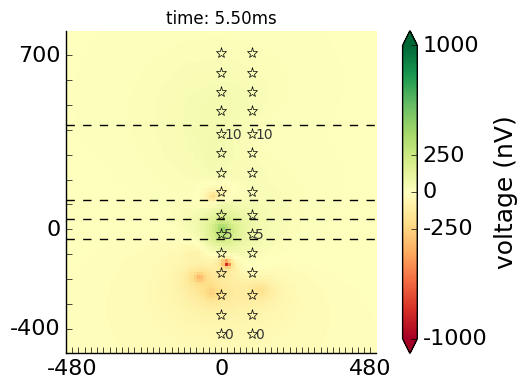

In [8]:
params_cell_file = os.path.join(dir_name, file_name) + '.json'

with file(params_cell_file, 'r') as fid:
    params_cell = json.load(fid)
dt = params_cell['timestep']

results_file = os.path.join(dir_name, file_name, 'results_all.npz')
results = np.load(results_file)
v_ext = results['v_ext']
x_range = params_cell['record_x_range']
y_range = params_cell['record_y_range']

if final_time is not None:
    final_time_pt = int(final_time/dt)
    v_ext = v_ext[:final_time_pt,:,:]

if 'region_layer_ranges' in params_cell.keys():
    layers = params_cell['region_layer_ranges']
else:
    layers = None
    
time_pt = int(time_ms / dt)

fig = plt.figure()
ax_field = plt.subplot(111)
# plot field
params = v_ext, np.nan, np.nan, np.nan, x_range, y_range, dt
mycmap, colormap_range = cplt.plot_memb_current_for_cell(time_pt, params, plot_morpho=False, plot_field=True,
                                                        plot_synapses=False, plot_current=False, ax=ax_field)
y_values = np.floor(np.linspace(0, v_ext.shape[1], no_y_values + 2))[1:-1]
    # plot electrode locations
for x_val in x_values:
    cplt.plot_electrode_locs(ax_field, v_ext, y_values, y_range, x_value=x_val, no_y_values=24)

if layers != None:
    for layer in layers[1:]:
        ax_field.hlines(y=layer[0],xmin=x_range[0], xmax=x_range[1], linestyles='--')
plt.savefig(os.path.join(final_figs_dir, 'lfp_fields_electrodes') + ext)

lib/cell_plot.py:350: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  trace = v_ext[:len(timeline),y_value, x_value_vext]


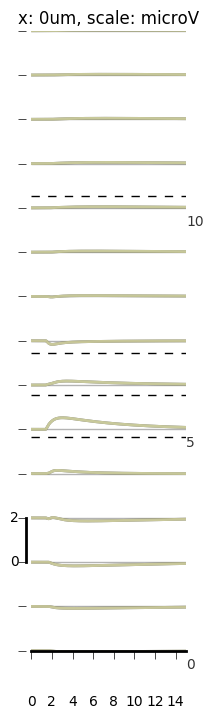

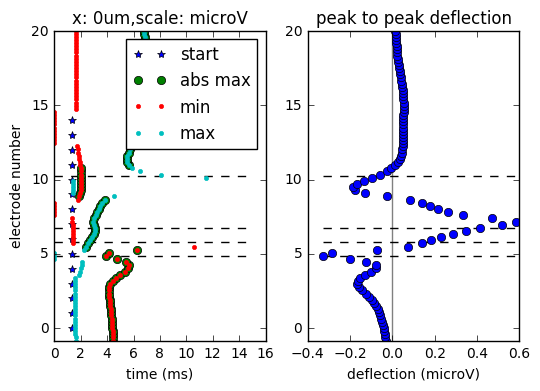

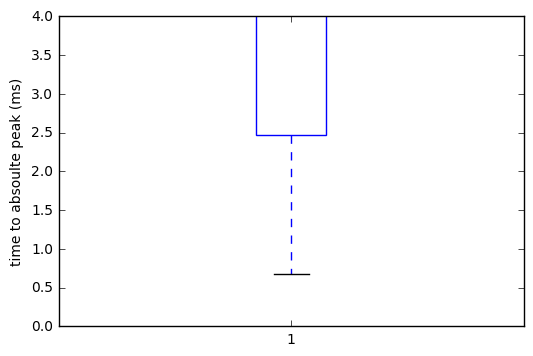

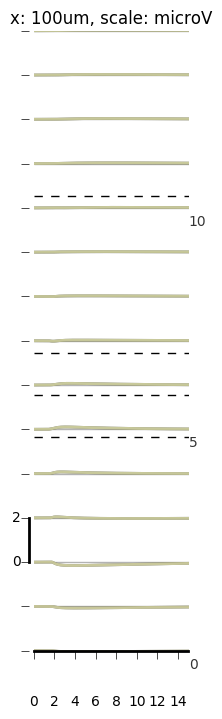

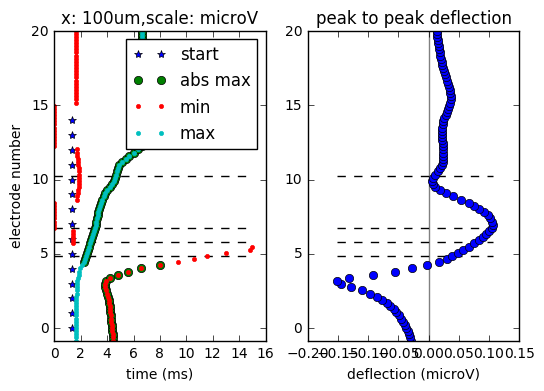

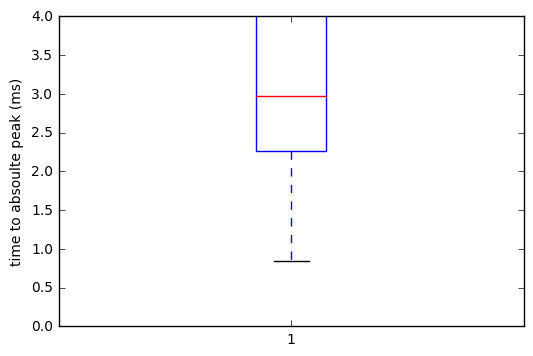

In [9]:
# plot traces

for x_val in x_values:
    plt.figure(figsize=(2, 8))
    ax_traces = plt.subplot(111)
    cplt.plot_traces(ax_traces, v_ext, dt, mycmap, colormap_range, layers,
                            x_range, y_range, y_values, x_value = x_val, get_params=True,
                              final_figs_dir=final_figs_dir, ext=ext)
